<a href="https://colab.research.google.com/github/kylemath/eeg-notebooks/blob/master/notebooks/Deep_eeg_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep-eeg-notebooks

Goal is to make a deep learning LSTM stack that processes Muse eeg-notebook EEG trials as input and predicts binary trial category as output. This is all made to run on Google Colab notebooks using cloud GPU capabilities, so the git repo's get loaded at the start of the code into the workspace. Minor mods may be needed to use local Jupyter notebook. Long term goal of command line interface and mne toolbox.

Strategy:
* Load in Muse data, normal pre-processing to get to trials
* Decimate down to reduce features in time x frequency x electrode
* Avoid CNN?
* load time steps into LSTM?
* Predict attend left vs attend right on muse 375 data

API:
* Want to input the data directory of any eeg-notebook experiment (https://github.com/kylemath/eeg-notebooks)
* More general with the master eeg-notebooks - https://github.com/NeuroTechX/eeg-notebooks


LearningModels:
* First try simple CNN
* then add in LSTM component to treat time as recurrent

DataModels:
* First pool data over subjects
* Try subject specific models
* Then try multilevel models

Using: 
* https://github.com/pbashivan/EEGLearn
* https://github.com/tevisgehr/EEG-Classification
* https://github.com/kylemath/eeg-notebooks
* https://github.com/mne-tools/mne-python
* https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
* https://github.com/ml4a/ml4a-guides/blob/master/notebooks/keras_classification.ipynb

Resources:
*   http://proceedings.mlr.press/v56/Thodoroff16.pdf
*   https://arxiv.org/abs/1511.06448




**Setup**

In [12]:
!pip install mne
from mne import Epochs, find_events, concatenate_raws
from mne.time_frequency import tfr_morlet

!git clone https://github.com/kylemath/eeg-notebooks.git
%cd eeg-notebooks/notebooks
from utils import utils

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.precision = 4

import numpy as np
from numpy import genfromtxt

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,12)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
from keras.layers import Flatten, Conv2D, MaxPooling2D, LSTM
from sklearn.model_selection import train_test_split

Cloning into 'eeg-notebooks'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 1724 (delta 119), reused 143 (delta 43), pack-reused 1466
Receiving objects: 100% (1724/1724), 108.20 MiB | 21.61 MiB/s, done.
Resolving deltas: 100% (742/742), done.
Checking out files: 100% (485/485), done.
/content/eeg-notebooks/notebooks/eeg-notebooks/notebooks


**Parameters**

In [13]:
#Parameters#
#subject folders in data folder
subs = [101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112,
        202, 203, 204, 205, 207, 208, 209, 210, 211, 
        301, 302, 303, 304, 305, 306, 307, 308, 309]

#for testing
subs = [ 205, 207, 208, 209]

#number of sessions in each subject folder
nsesh = 2

data_dir = 'visual/cueing'
event_ids = ['LeftCue','RightCue']


## Can load other experiments like this
#subs = [ 1, 2, 3]
#nsesh = 2
#data_dir = 'visual/P300'
#event_ids = ['Standard','Target']
##

load_verbose = 0 #print output during loading


sfreq=256.

#filter
eeg_filter_highpass = 1
eeg_filter_lowpass = 30

#artifact rejection
rej_thresh_uV = 1000  #300 removes most blinks, 1000 keeps most trials
rej_thresh = rej_thresh_uV*1e-6

#trial epoch limits 
tmin=-1
tmax=2
decim=20  # to decrease number of time features
baseline=(-1, 0) #gets removed from training data but used during processing

frequency_domain = 0  #if True uses wavelets otherwise use time series
#wavelet settings
f_low = 4
f_high = 20
f_bins = 10  # to decrease number of frequency features
frequencies =  np.linspace(4, 10, f_bins, endpoint=True)
wave_cycles = 6
spect_baseline = [-1,-.5] #gets removed from training data but used during processing
electrodes_out = [0,1,2,3]  # to decrease number of electrode features from [0,1,2,3] or [0,1,2,3,4] with aux electrode (untested)

#Training Settings
batch_size = 16
train_epochs = 100
num_classes = len(event_ids)
test_split = 0.2
val_split = 0.2
random_seed = 1017
np.random.seed(random_seed)


print('Parameters Set')

Parameters Set


**Preprocessing of EEG Data**

* LoadData - Each data file is from one session of one subject of the muse cueing task from eeg-notebooks from psych 375 A1 dataset
* Filtering - Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.
* Epoching - Next, we will chunk (epoch) the data into segments representing the data 1000ms before to 2000ms after each cue, we will reject every epoch where the amplitude of the signal exceeded 100 uV, which should most eye blinks.

In [14]:
#Load Data
print('Loading Data')
isub = subs[0]
print(isub)
raw = utils.load_data(data_dir, sfreq=sfreq ,subject_nb=isub, session_nb=1,verbose=load_verbose)
if nsesh == 2:
  raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))

if len(subs)>1:
  for isub in subs[1:]:
    print(isub)
    raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=1,verbose=load_verbose))
    if nsesh == 2:
      raw.append(utils.load_data(data_dir, sfreq=sfreq,subject_nb=isub, session_nb=2,verbose=load_verbose))
  
#Filtering
print('Filtering Data')
raw.filter(eeg_filter_highpass,eeg_filter_lowpass, method='iir', verbose='WARNING' )

#Plot filtred data spectra if desired
#raw.plot_psd(fmin=eeg_filter_highpass, fmax=eeg_filter_lowpass ) 

#Epoching
event_id = {event_ids[0]: 1, event_ids[1]: 2}
events = find_events(raw)
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=tmin, tmax=tmax, baseline=baseline, 
                preload=True,reject={'eeg':rej_thresh},
                verbose=False, picks=[0, 1, 2, 3])

print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
%matplotlib inline
conditions = OrderedDict()
conditions[event_ids[0]] = [1]
conditions[event_ids[1]] = [2]

#plot ERPs if desired
#fig, ax = utils.plot_conditions(epochs, conditions=conditions, ylim=(-20,20) )

Loading Data
205
207
208
209
Filtering Data
674 events found
Event IDs: [ 1  2 11 12 21 22]
sample drop %:  50.29673590504451


** Spectrogram **

* All electrodes are considered on each trial
* Many frequencies are used in the wavelet analysis while the output of the morlet is decimated in time.
* Two conditions are done separate and concatenated
* X is a trials x freq x time matrix
* Y is a trials array of condition labels (turned into one hot vectors later in code)


In [0]:
if frequency_domain:
  # Condition0
  print('Computing Morlet Wavelets on ' + event_ids[0])

  tfr0 = tfr_morlet(epochs[event_ids[0]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=decim)
  tfr0 = tfr0.apply_baseline(spect_baseline,mode='mean')
  stim_onset = np.argmax(tfr0.times>0)
  new_times = tfr0.times[stim_onset:]
  cond0_power_out = np.moveaxis(tfr0.data[:,:,:,stim_onset:],1,3)
  print('Condition zero trials: ' + str(len(cond0_power_out)))
  #cond0_power_out[:,0:5,0:5,:] = 0 #for testing model add mark to image

  print(event_ids[0] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[0] + ' Frequencies: ' + str(len(tfr0.freqs)))

  #Condition1
  print('Computing Morlet Wavelets on ' + event_ids[1])
  tfr1 = tfr_morlet(epochs[event_ids[1]], freqs=frequencies, 
                        n_cycles=wave_cycles, return_itc=False,
                        picks=electrodes_out,average=False,decim=decim)
  tfr1 = tfr1.apply_baseline(spect_baseline,mode='mean')
  cond1_power_out = np.moveaxis(tfr1.data[:,:,:,stim_onset:],1,3)
  print('Condition one trials: ' + str(len(cond1_power_out)))    
  #cond1_power_out[:,0:5,0:5,:] = 1 #for testing model add mark to image

  print(event_ids[1] + ' Time Points: ' + str(len(new_times)))
  print(event_ids[1] + ' Frequencies: ' + str(len(tfr1.freqs)))

  X = np.append(cond0_power_out,cond1_power_out,0);
  
  #Normalize X - need to save mean and std for future test + val
  X = (X - np.mean(X)) / np.std(X)
  #Append Data
  Y = np.append(np.zeros(len(cond0_power_out)), np.ones(len(cond1_power_out)),0)

**Time Domain**

* Instead may want to retain time domain data
* After Epoching, arange data into useful format with labels

In [16]:
if not frequency_domain:
  
  #epochs = epochs.decimate(10) #probably don't do this
  X = np.moveaxis(epochs._data,1,2); #but channels last
  
  #take post baseline only
  stim_onset = np.argmax(epochs.times>0)
  new_times = epochs.times[stim_onset:]
  X = X[:,stim_onset:,:]
  
  #Normalize X - need to save mean and std for future test + val
  X = (X - np.mean(X)) / np.std(X)
  
  Y_class = epochs.events[:,2]-1  #subtract 1 to make 0 and 1
  
  print('X Shape: ' + str(X.shape))
  print('Y Shape: ' + str(Y_class.shape))
  print('Y Example: ' + str(Y_class[0:10]))

X Shape: (335, 512, 4)
Y Shape: (335,)
Y Example: [0 0 0 0 0 0 1 1 1 0]


**Prepare Data for Model**


Combined X Shape: (335, 512, 4)
Combined Y Shape: (335, 2)
X Range: -21.438705:13.131357
X Examples:
Input Shape: (512, 4)
x_train shape: (201, 512, 4)
201 train samples
67 test samples
67 validation samples


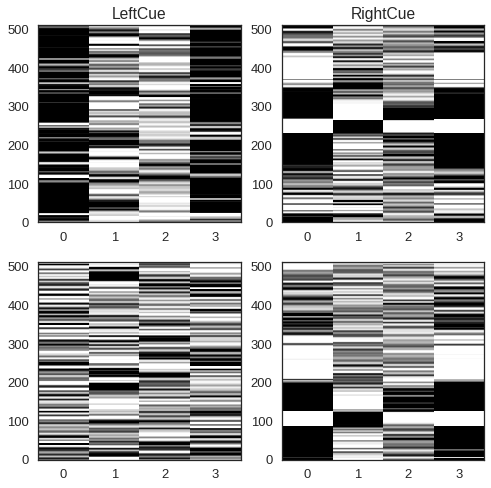

In [17]:
# convert class vectors to one hot Y and recast X
Y = keras.utils.to_categorical(Y_class, num_classes)
X = X.astype('float32')

# Split training test and validation data 
val_prop = val_split / (1-test_split)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_split,random_state=random_seed) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_prop, random_state=random_seed)

# Compute model input shape
input_shape = X.shape[1:]

print('Combined X Shape: ' + str(X.shape))
print('Combined Y Shape: ' + str(Y.shape))
print('X Range: ' + str(np.min(X)) + ':' + str(np.max(X)))
print('X Examples:')

#for plotting

vmin = (np.std(X)/4) * -1
vmax = np.std(X)/4  

#Plot Example Data
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title(event_ids[0])
axarr[0][0].imshow(X[0],vmin=vmin, vmax=vmax, aspect='auto')

axarr[0][0].invert_yaxis()
axarr[1][0].imshow(X[1],vmin=vmin, vmax=vmax, aspect='auto')
axarr[1][0].invert_yaxis()

axarr[0][1].set_title(event_ids[1])
axarr[0][1].imshow(X[-1],vmin=vmin, vmax=vmax, aspect='auto')
axarr[0][1].invert_yaxis()
axarr[1][1].imshow(X[-2],vmin=vmin, vmax=vmax, aspect='auto')
axarr[1][1].invert_yaxis()
;

print('Input Shape: ' + str(input_shape))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validation samples')


**Build Model and Train**

In [25]:
##---LSTM - Many to two, sequence of time to electrodes
units = [input_shape[1], 4, 2, num_classes]
model = Sequential()
model.add(LSTM(input_shape=(None, units[0]) ,units=units[1], return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=units[2],return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=units[3]))
model.add(Activation("softmax"))

##---DenseFeedforward Network
#model = Sequential()
#model.add(Flatten())
#model.add(Dense(10, activation='relu'))
#model.add(Dropout(.20))
#model.add(Dense(num_classes, activation='softmax'))

##----Convolutional Network
# parameters above need to be adjusted until input shape is square on 
# dimensions 1 and 2 (like an image) and electrodes on third

#model = Sequential()
#model.add(Conv2D(49, (3, 3), input_shape=input_shape))
#model.add(Activation('relu'))
#model.add(Conv2D(32, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(10))
#model.add(Activation('relu'))
#model.add(Dense(num_classes))
#model.add(Activation('softmax'))

# initiate adam optimizer
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, 
                            epsilon=None, decay=0.0, amsgrad=False)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



#Train Model
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=train_epochs,
          validation_data=(x_val, y_val),
          shuffle=True,
          verbose=True)
         
#Summarize
model.summary()
 
  
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test on left out Test data
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train on 201 samples, validate on 67 samples
Epoch 1/100
201/201 [==============================] - 28s 140ms/step - loss: 0.7090 - acc: 0.4627 - val_loss: 0.6903 - val_acc: 0.5821
Epoch 2/100
176/201 [=========================>....] - ETA: 2s - loss: 0.7006 - acc: 0.4716

KeyboardInterrupt: ignored